In [1]:
import torch
import torch.nn as nn
import torchvision
from robustness import model_utils, datasets
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
from src.models import get_model
from src.ema import EMAHelper
from src.dataset import create_dataset

/home/alvin/miniconda3/envs/generative-flow/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Change relevant paths here

In [10]:
# path to LR-KL checkpoint
ckpt_path = "path/to/CIFAR10 LR KL checkpoint"

# path to robust classifier checkpoint
classifier_path = "cifar_l2_1_0.pt"

# path to CIFAR10 DDP
ddp_path = "cifar10_ddp.pt"

# if None, use the device of the saved checkpoint. else replace with "cpu", "cuda:0" or list of device ids [0, 1] etc
device = "cuda:0"

# dataset directory containing the folder cifar-10-batches-py
data_dir = "path/to/data dir"

In [11]:
# Load gradient flow model
ckpt = torch.load(ckpt_path)
config = ckpt['config']
if device is None:
    device = config['device']

if isinstance(device, list):
    multi_gpu = True
    device_ids = device
    device = 'cuda:' + str(device_ids[0]) # if multi-GPUs, set default device to the first gpu
else:
    multi_gpu = False

model = get_model(config)
if multi_gpu:
    model = nn.DataParallel(model, device_ids=device_ids)

if config['ema']:
    ema_helper = EMAHelper(mu=config['ema_rate'])
    ema_helper.load_state_dict(ckpt['ema'])
    model = ema_helper.ema_copy(model)
else:
    model.load_state_dict(ckpt['model'])
model = model.to(device)
print(f"Loading checkpoint step {ckpt['step']}")

# Load robust classifier
dataset = datasets.CIFAR(data_dir)
classifier, _ = model_utils.make_and_restore_model(arch='resnet50', dataset=dataset, resume_path=classifier_path)
classifier.eval().to(device);

# Load learned prior
ddp = torch.load(ddp_path)

Loading checkpoint step 119999
=> loading checkpoint 'cifar_l2_1_0.pt'
=> loaded checkpoint 'cifar_l2_1_0.pt' (epoch 105)


In [12]:
from torch.nn.functional import softmax

def one_step_flow(x, model, classifier, y, eta, noise_factor, f_divergence):

    x_k = torch.autograd.Variable(x.clone(), requires_grad=True)
    dr = model(x_k)
    class_prob = softmax(classifier((x_k+1.)/2.)[0], dim=-1)[:, y]
    grad = torch.autograd.grad(dr.sum(), [x_k])[0] - 0.1 * (torch.autograd.grad(torch.log(class_prob).sum(), [x_k])[0])
    x_k.data -= eta * grad + noise_factor * torch.randn_like(x_k)
    return x_k.detach()

In [13]:
bs = 64
f_divergence = config['f_divergence']
eta = config['eta']
noise_factor = config['noise_factor']
loss_func = config['loss_function']
n_flow_steps = config['n_flow_steps']

In [14]:
from tqdm import tqdm

class_conditional_x = []

for i in tqdm(range(20)):
    class_x = ddp.sample([10]).reshape(-1,3, 
                    config['img_size'], config['img_size']).clamp(-1.,1.).to(device)
    
    for j in range(n_flow_steps+10):
        class_x = one_step_flow(class_x, model, classifier, i, eta, noise_factor, f_divergence)
        
    class_conditional_x.append(class_x.clamp(-1., 1.).detach().cpu())
    
class_conditional_x = torch.cat(class_conditional_x)

100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.54s/it]


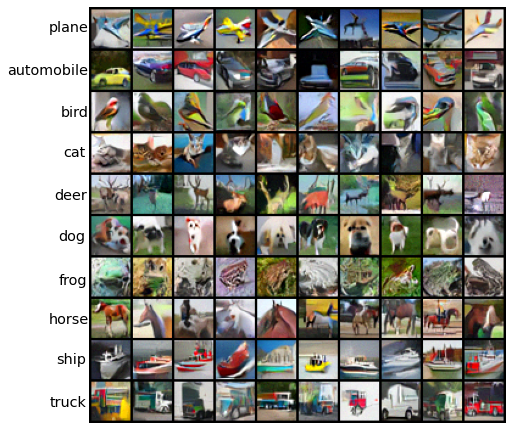

In [66]:
grid = make_grid(class_conditional_x, nrow=10, normalize=True)
f = plt.figure(figsize=(8,6))
plt.imshow(grid.permute(1, 2, 0))
plt.text(-34, 20, "plane",fontsize = 'x-large')
plt.text(-68, 55, "automobile",fontsize = 'x-large')
plt.text(-24, 90, "bird",fontsize = 'x-large')
plt.text(-22, 123, "cat",fontsize = 'x-large')
plt.text(-29, 158, "deer",fontsize = 'x-large')
plt.text(-26, 192, "dog",fontsize = 'x-large')
plt.text(-26, 228, "frog",fontsize = 'x-large')
plt.text(-34, 260, "horse",fontsize = 'x-large')
plt.text(-28, 293, "ship",fontsize = 'x-large')
plt.text(-33, 328, "truck",fontsize = 'x-large')
plt.axis("off")
plt.tight_layout(pad=0.8)
plt.show()